### Using Python version 3.6 and Tensorflow version 1.7

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.set_random_seed(10)
np.random.seed(5)
import time
import sys

### 1. (10pts) Define functions

In [2]:
# One hot encode the labels
def one_hot_encode(y):
    targets = np.array(np.unique(y)).reshape(-1)
    enc = np.eye(len(targets))[y]
    return enc

#Get the accuracy of the results
def get_accuracy(y, y_pred):
    y = tf.nn.softmax(y)
    y_pred = tf.nn.softmax(y_pred)
    labels_equal = tf.equal(y, y_pred)
    accuracy = tf.reduce_mean(tf.cast(labels_equal, 'float'))
    return accuracy

# Get the cost of iteration
def get_cost(y, y_pred):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y))
    return cost

def plotCostHistory(cost_history):
     plt.plot(cost_history)
     plt.ylabel('Cost');
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations')
     plt.show()

def extract_parameters(hyper_params, key):
    hyper_param = hyper_params[key]
    pad = hyper_param["pad"]
    f = hyper_param["f"]
    stride = hyper_param["stride"]
    filters = hyper_param["channels"]
    #a_prev = tf.pad(a_prev, [[0, 0], [pad, pad], [pad, pad], [0, 0]], "CONSTANT")
    return pad, f, stride, filters

# Flatten the array
def flatten(A):
    return tf.layers.flatten(A)

# Forward propagation to calculate yHat
def forward_propagate_lenet5(x, hyper_params, keep_prob, lamda):

    # Layer 1 Convolution 
    pad_c1, f_c1, stride_c1, filters_out_c1 =  extract_parameters(hyper_params, "c1")
    a1_c = tf.layers.conv2d(inputs=x, filters=filters_out_c1, kernel_size=[f_c1,f_c1],strides=stride_c1, 
    kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1), kernel_regularizer=tf.contrib.layers.l2_regularizer(lamda), bias_initializer=tf.zeros_initializer(), 
                            padding='same',activation=tf.nn.relu) # Relu Activation
    a1_c = tf.nn.dropout(a1_c, keep_prob, seed=2)
    
    print(a1_c)
    
    # Layer 1 Pooling 
    pad_p1, f_p1, stride_p1, filters_out_p1 =  extract_parameters(hyper_params, "p1")
    print(f_p1)
    a1_p = tf.layers.max_pooling2d(inputs = a1_c,pool_size=[f_p1,f_p1], strides=stride_p1)
    print(a1_p)
    a1_p = tf.nn.dropout(a1_p, keep_prob, seed=2)
 
    # Layer 2 Convolution 
    
    pad_c2, f_c2, stride_c2, filters_out_c2 =  extract_parameters(hyper_params, "c2")
    print(" pad {} f {} stid {} filters {}".format(pad_c2, f_c2, stride_c2, filters_out_c2))
    a2_c = tf.layers.conv2d(inputs = a1_p, filters=filters_out_c2, kernel_size=[f_c2,f_c2],
           kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1), kernel_regularizer=tf.contrib.layers.l2_regularizer(lamda), bias_initializer=tf.zeros_initializer(), 
                    strides=stride_c2, padding='valid' , activation=tf.nn.relu) # Relu Activation
    print(a2_c)
    a2_c = tf.nn.dropout(a2_c, keep_prob, seed=2)
    
    # Layer 2 Pooling 
    pad_p2, f_p2, stride_p2, filters_out_p2 =  extract_parameters(hyper_params, "p2")
    a2_p = tf.layers.average_pooling2d(inputs = a2_c, pool_size=[f_p2,f_p2], strides=stride_p2)
    a2_p = tf.nn.dropout(a2_p, keep_prob, seed=2)
    
    print(a2_p)
    # Flatten the array
    a3 = flatten(a2_p)
    print(a3)
    

    # Fully Connected Layer 4
    fc1_size = hyper_params["4"]["size"]
    a4 = tf.layers.dense(inputs = a3, units=fc1_size, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    a4 = tf.nn.dropout(a4, keep_prob, seed=2)
    print(a4)
    
    
    # Fully Connected Layer 5
    fc2_size = hyper_params["5"]["size"]
    a5 = tf.layers.dense(inputs = a4, units=fc2_size, activation=tf.nn.sigmoid, kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    print(a5)
    return a5

### 2. Load data

In [3]:
# Load Training Data
X_train = np.load('exam2_train_x.npy')
y_train = np.load('exam2_train_y.npy')
# indx = 2
# plt.imshow(X_train[indx])
# plt.show()
# print("Digit in the image is " + str(y_train[indx]))

# Normalize the training data
X_train_norm = (X_train/255.0) - 0.5
y_train_encoded = one_hot_encode(y_train)

# Load testing Data
X_test = np.load('exam2_test_x.npy')
y_test = np.load('exam2_test_y.npy')
# indx = 2
# plt.imshow(X_test[indx])
# plt.show()
# print("Digit in the image is " + str(y_test[indx]))

# Normalize the test data
X_test_norm = (X_test/255.0) - 0.5
y_test_encoded = one_hot_encode(y_test)
print(X_test_norm.shape)
print(X_train_norm.shape)

print(y_train_encoded.shape)
print(y_test_encoded.shape)

(180, 64, 64, 3)
(1020, 64, 64, 3)
(1020, 6)
(180, 6)


### 3. (10pts) Initialize parameters (Weights, bias for each layer)

In [4]:
def initialize_hyper_params():
    
    hyper_params = {}
    
    # Convolution Layer 1 Hyper Parameters
    hyper_params_c1 = {}
    hyper_params_c1["stride"] = 2
    hyper_params_c1["pad"] = 1
    hyper_params_c1["f"] = 4
    hyper_params_c1["channels"] = 8
    
    # Pooling Layer 1 Hyper Parameters
    hyper_params_p1 = {}
    hyper_params_p1["stride"] = 1
    hyper_params_p1["pad"] = 0
    hyper_params_p1["f"] = 5
    hyper_params_p1["channels"] = 8
    
    # Convolution Layer 2 Hyper Parameters
    hyper_params_c2 = {}
    hyper_params_c2["stride"] = 2
    hyper_params_c2["pad"] = 0
    hyper_params_c2["f"] = 4
    hyper_params_c2["channels"] = 16
    
    # Pooling Layer 2 Hyper Parameters
    hyper_params_p2 = {}
    hyper_params_p2["stride"] = 1
    hyper_params_p2["pad"] = 0
    hyper_params_p2["f"] = 5
    hyper_params_p2["channels"] = 16
    
    hyper_params_4 = {}
    hyper_params_4["size"] = 108
            
    hyper_params_5 = {}
    hyper_params_5["size"] = 6
    
    hyper_params["c1"] = hyper_params_c1
    hyper_params["p1"] = hyper_params_p1
    
    hyper_params["c2"] = hyper_params_c2
    hyper_params["p2"] = hyper_params_p2
    
    hyper_params["4"] = hyper_params_4
    hyper_params["5"] = hyper_params_5
    
    return hyper_params

In [5]:
# hyper_params = initialize_hyper_params()
# (m, nH, nW, nC) = X_train_norm.shape
# X_train_norm = tf.placeholder(tf.float32, [None, nH, nW, nC])
# print(X_train_norm.shape)
# y_pred = forward_propagate_lenet5(X_train_norm, hyper_params)

In [6]:
# hyper_params = initialize_hyper_params()
# (m, nH, nW, nC) = X_train_norm.shape
# x = tf.placeholder(tf.float32, [None, nH, nW, nC])
# y = tf.placeholder(tf.float32)
# y_pred = tf.placeholder(tf.float32)
# y_pred = forward_propagate_lenet5(x, hyper_params)
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y))

# optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

# init = tf.global_variables_initializer()

# with tf.Session() as sess:
#     sess.run(init)
#     for epoch in range(1000):
#         _, c = sess.run([optimizer, cost], feed_dict = {x: X_train_norm, y: y_train_encoded})
#         if epoch % 10 == 0:
#             print ("Epoch:", (epoch), "cost =", "{:.5f}".format(c))
#             #print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)) 
#     actual_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
#     accuracy = tf.reduce_mean(tf.cast(actual_prediction, tf.float32))
#     accuracy_tr = accuracy.eval({x: X_train_norm, y: y_train_encoded})
#     accuracy_te = accuracy.eval({x: X_test_norm, y: y_test_encoded})
#     print ("Accuracy on Train Dataset using keep_prob = " + " :", accuracy_tr)
#     print("Accuracy on Test Dataset using keep_prob = "+ " :", accuracy_te)
# elapsed_time = time.time() - start_time
# print ("Time taken to run: ", float(elapsed_time/60))

### 4. (40pts) Build Convolution Neural Network model

In [7]:
def train_cnn_lenet5(epochs, X_train, y_train, X_test, y_test, learning_rate, keep_prob, lamda):
    tf.reset_default_graph()
    (m, nH, nW, nC) = X_train.shape
    x = tf.placeholder(tf.float32, [None, nH, nW, nC])
    y = tf.placeholder(tf.float32)
    hyper_params = initialize_hyper_params()
    y_pred = forward_propagate_lenet5(x, hyper_params, keep_prob, lamda)
    cost = get_cost(y, y_pred)
    
    # The AdamOptimizer is used to optimize the cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) 
    init = tf.global_variables_initializer()
    correctness = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1)) # Softmax Predictions
    accuracy = tf.reduce_mean(tf.cast(correctness, 'float'))
    cost_history = []
    max_test_acc = 0
    max_iter = 0
    train_acc = 0
    test_acc = 0
    old_cost = sys.maxsize
    new_cost = sys.maxsize
    with tf.Session() as sess:
        sess.run(init)
        start_time = time.time() 
        for epoch in range(epochs+1):
            old_cost = new_cost
            temp, epoch_cost = sess.run([optimizer, cost], feed_dict={x:X_train, y:y_train})
            new_cost = epoch_cost
            cost_history.append(epoch_cost)
            if(abs(old_cost - new_cost) < 0.00000000001):
                print("breaking" + str(old_cost) + str(new_cost))
                break;
            if(epoch % 1 == 0):
                train_acc = accuracy.eval({x:X_train, y:y_train})
                test_acc = accuracy.eval({x:X_test, y:y_test}) 
                if(test_acc > max_test_acc):
                    max_test_acc = test_acc
                    print('Max till now is ' , float(max_test_acc))
                    max_iter = epoch
                print('Accuracy Test: ' + str(test_acc) + ' on iteration ' + str(epoch))
                print('Cost is ' + str(epoch_cost) + ' for iteration: ' + str(epoch))
        plotCostHistory(cost_history)
        train_acc = train_acc * 100.0
        test_acc = test_acc * 100.0
        print('Train Accuracy: ', train_acc)
        print('Test Accuracy: ' ,test_acc)
        print('Max Test Accuracy: ' + str(max_test_acc* 100.0) + ' on iteration ' + str(max_iter))
        print('Learning rate: ' , learning_rate)
        print('Keep probability: ' , keep_prob)
        elapsed_time = time.time() - start_time
        print("Time elapsed : " , float(elapsed_time/60))
        return train_acc, test_acc

### 5. (20pts) Optimization of Convolution Neural Network model

**********Learning rate******0.012********Keep prob***********0.95****lamda 10.0
Instructions for updating:
Use the retry module or similar alternatives.
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.25
Accuracy Test: 0.25 on iteration 0
Cost is 1.7919111 for iteration: 0
Accuracy Test: 0.2 on iteration 1
Cost is 1.7860423 for iteration: 1
Accuracy Test: 0.21666667 on iteration 2
Cost is 1.8157321 for iteration: 2
Max till now is  0.3333333432674408
Accuracy Test: 0.33333334 on iteration 3
Cost is 1.7869505 for iteration: 3
Accuracy Test: 0.24444444 on itera

Max till now is  0.855555534362793
Accuracy Test: 0.85555553 on iteration 85
Cost is 1.1517472 for iteration: 85
Accuracy Test: 0.81666666 on iteration 86
Cost is 1.1441935 for iteration: 86
Accuracy Test: 0.8055556 on iteration 87
Cost is 1.1454239 for iteration: 87
Accuracy Test: 0.81666666 on iteration 88
Cost is 1.1431131 for iteration: 88
Accuracy Test: 0.8333333 on iteration 89
Cost is 1.1447726 for iteration: 89
Accuracy Test: 0.8333333 on iteration 90
Cost is 1.1410264 for iteration: 90
Accuracy Test: 0.84444445 on iteration 91
Cost is 1.1413485 for iteration: 91
Max till now is  0.8611111044883728
Accuracy Test: 0.8611111 on iteration 92
Cost is 1.1416879 for iteration: 92
Accuracy Test: 0.8333333 on iteration 93
Cost is 1.1319308 for iteration: 93
Accuracy Test: 0.85555553 on iteration 94
Cost is 1.1329836 for iteration: 94
Max till now is  0.8666666746139526
Accuracy Test: 0.8666667 on iteration 95
Cost is 1.1290357 for iteration: 95
Accuracy Test: 0.84444445 on iteration 96

Max till now is  0.9611111283302307
Accuracy Test: 0.9611111 on iteration 185
Cost is 1.0675824 for iteration: 185
Accuracy Test: 0.9444444 on iteration 186
Cost is 1.0694456 for iteration: 186
Accuracy Test: 0.93333334 on iteration 187
Cost is 1.0753753 for iteration: 187
Accuracy Test: 0.9222222 on iteration 188
Cost is 1.0714173 for iteration: 188
Accuracy Test: 0.92777777 on iteration 189
Cost is 1.0711133 for iteration: 189
Accuracy Test: 0.93333334 on iteration 190
Cost is 1.0728911 for iteration: 190
Accuracy Test: 0.93333334 on iteration 191
Cost is 1.0667953 for iteration: 191
Accuracy Test: 0.9166667 on iteration 192
Cost is 1.0762955 for iteration: 192
Accuracy Test: 0.9222222 on iteration 193
Cost is 1.067635 for iteration: 193
Accuracy Test: 0.92777777 on iteration 194
Cost is 1.0678451 for iteration: 194
Accuracy Test: 0.9111111 on iteration 195
Cost is 1.0706441 for iteration: 195
Accuracy Test: 0.95555556 on iteration 196
Cost is 1.0732559 for iteration: 196
Accuracy Te

Accuracy Test: 0.95555556 on iteration 290
Cost is 1.055324 for iteration: 290
Max till now is  0.9666666388511658
Accuracy Test: 0.96666664 on iteration 291
Cost is 1.0583196 for iteration: 291
Accuracy Test: 0.93333334 on iteration 292
Cost is 1.0555633 for iteration: 292
Accuracy Test: 0.93333334 on iteration 293
Cost is 1.0599025 for iteration: 293
Accuracy Test: 0.95555556 on iteration 294
Cost is 1.0580066 for iteration: 294
Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0594536 for iteration: 295
Accuracy Test: 0.95 on iteration 296
Cost is 1.0575057 for iteration: 296
Accuracy Test: 0.9388889 on iteration 297
Cost is 1.0562352 for iteration: 297
Accuracy Test: 0.93333334 on iteration 298
Cost is 1.0604283 for iteration: 298
Accuracy Test: 0.96666664 on iteration 299
Cost is 1.0607768 for iteration: 299
Accuracy Test: 0.9388889 on iteration 300
Cost is 1.0588686 for iteration: 300
Accuracy Test: 0.9388889 on iteration 301
Cost is 1.0603615 for iteration: 301
Accuracy Test:

Accuracy Test: 0.9611111 on iteration 395
Cost is 1.0618412 for iteration: 395
Accuracy Test: 0.9444444 on iteration 396
Cost is 1.0555294 for iteration: 396
Accuracy Test: 0.9111111 on iteration 397
Cost is 1.0563328 for iteration: 397
Accuracy Test: 0.9611111 on iteration 398
Cost is 1.0638243 for iteration: 398
Accuracy Test: 0.95 on iteration 399
Cost is 1.0584116 for iteration: 399
Accuracy Test: 0.95 on iteration 400
Cost is 1.0548385 for iteration: 400
Accuracy Test: 0.9444444 on iteration 401
Cost is 1.0607178 for iteration: 401
Accuracy Test: 0.9388889 on iteration 402
Cost is 1.0578843 for iteration: 402
Accuracy Test: 0.9388889 on iteration 403
Cost is 1.0564348 for iteration: 403
Accuracy Test: 0.9222222 on iteration 404
Cost is 1.0545161 for iteration: 404
Accuracy Test: 0.96666664 on iteration 405
Cost is 1.061866 for iteration: 405
Accuracy Test: 0.9444444 on iteration 406
Cost is 1.053497 for iteration: 406
Accuracy Test: 0.93333334 on iteration 407
Cost is 1.0590595 fo

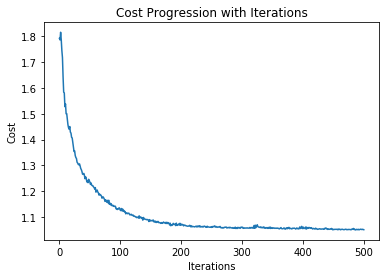

Train Accuracy:  99.41176176071167
Test Accuracy:  93.88889074325562
Max Test Accuracy: 97.22222089767456 on iteration 364
Learning rate:  0.012
Keep probability:  0.95
Time elapsed :  9.323180798689524
**********Learning rate******0.012********Keep prob***********0.95****lamda 0.1
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.25
Accuracy Test: 0.25 on iteration 0
Cost is 1.7919111 for iteration: 0
Accuracy Test: 0.2 on iteration 1
Cost is 1.7860423 for iteration: 1
Accuracy Test: 0.21666667 on iteration 2
Cost is 1.8157321 for iteration: 2
Max till now is  

Accuracy Test: 0.81666666 on iteration 86
Cost is 1.1441935 for iteration: 86
Accuracy Test: 0.8055556 on iteration 87
Cost is 1.1454239 for iteration: 87
Accuracy Test: 0.81666666 on iteration 88
Cost is 1.1431131 for iteration: 88
Accuracy Test: 0.8333333 on iteration 89
Cost is 1.1447726 for iteration: 89
Accuracy Test: 0.8333333 on iteration 90
Cost is 1.1410264 for iteration: 90
Accuracy Test: 0.84444445 on iteration 91
Cost is 1.1413485 for iteration: 91
Max till now is  0.8611111044883728
Accuracy Test: 0.8611111 on iteration 92
Cost is 1.1416879 for iteration: 92
Accuracy Test: 0.8333333 on iteration 93
Cost is 1.1319308 for iteration: 93
Accuracy Test: 0.85555553 on iteration 94
Cost is 1.1329836 for iteration: 94
Max till now is  0.8666666746139526
Accuracy Test: 0.8666667 on iteration 95
Cost is 1.1290357 for iteration: 95
Accuracy Test: 0.84444445 on iteration 96
Cost is 1.1305487 for iteration: 96
Accuracy Test: 0.84444445 on iteration 97
Cost is 1.1307522 for iteration: 9

Accuracy Test: 0.9444444 on iteration 186
Cost is 1.0694456 for iteration: 186
Accuracy Test: 0.93333334 on iteration 187
Cost is 1.0753753 for iteration: 187
Accuracy Test: 0.9222222 on iteration 188
Cost is 1.0714173 for iteration: 188
Accuracy Test: 0.92777777 on iteration 189
Cost is 1.0711133 for iteration: 189
Accuracy Test: 0.93333334 on iteration 190
Cost is 1.0728911 for iteration: 190
Accuracy Test: 0.93333334 on iteration 191
Cost is 1.0667953 for iteration: 191
Accuracy Test: 0.9166667 on iteration 192
Cost is 1.0762955 for iteration: 192
Accuracy Test: 0.9222222 on iteration 193
Cost is 1.067635 for iteration: 193
Accuracy Test: 0.92777777 on iteration 194
Cost is 1.0678451 for iteration: 194
Accuracy Test: 0.9111111 on iteration 195
Cost is 1.0706441 for iteration: 195
Accuracy Test: 0.95555556 on iteration 196
Cost is 1.0732559 for iteration: 196
Accuracy Test: 0.9388889 on iteration 197
Cost is 1.0690218 for iteration: 197
Accuracy Test: 0.92777777 on iteration 198
Cost

Max till now is  0.9666666388511658
Accuracy Test: 0.96666664 on iteration 291
Cost is 1.0583196 for iteration: 291
Accuracy Test: 0.93333334 on iteration 292
Cost is 1.0555633 for iteration: 292
Accuracy Test: 0.93333334 on iteration 293
Cost is 1.0599025 for iteration: 293
Accuracy Test: 0.95555556 on iteration 294
Cost is 1.0580066 for iteration: 294
Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0594536 for iteration: 295
Accuracy Test: 0.95 on iteration 296
Cost is 1.0575057 for iteration: 296
Accuracy Test: 0.9388889 on iteration 297
Cost is 1.0562352 for iteration: 297
Accuracy Test: 0.93333334 on iteration 298
Cost is 1.0604283 for iteration: 298
Accuracy Test: 0.96666664 on iteration 299
Cost is 1.0607768 for iteration: 299
Accuracy Test: 0.9388889 on iteration 300
Cost is 1.0588686 for iteration: 300
Accuracy Test: 0.9388889 on iteration 301
Cost is 1.0603615 for iteration: 301
Accuracy Test: 0.9222222 on iteration 302
Cost is 1.0563755 for iteration: 302
Accuracy Test:

Accuracy Test: 0.9444444 on iteration 396
Cost is 1.0555294 for iteration: 396
Accuracy Test: 0.9111111 on iteration 397
Cost is 1.0563328 for iteration: 397
Accuracy Test: 0.9611111 on iteration 398
Cost is 1.0638243 for iteration: 398
Accuracy Test: 0.95 on iteration 399
Cost is 1.0584116 for iteration: 399
Accuracy Test: 0.95 on iteration 400
Cost is 1.0548385 for iteration: 400
Accuracy Test: 0.9444444 on iteration 401
Cost is 1.0607178 for iteration: 401
Accuracy Test: 0.9388889 on iteration 402
Cost is 1.0578843 for iteration: 402
Accuracy Test: 0.9388889 on iteration 403
Cost is 1.0564348 for iteration: 403
Accuracy Test: 0.9222222 on iteration 404
Cost is 1.0545161 for iteration: 404
Accuracy Test: 0.96666664 on iteration 405
Cost is 1.061866 for iteration: 405
Accuracy Test: 0.9444444 on iteration 406
Cost is 1.053497 for iteration: 406
Accuracy Test: 0.93333334 on iteration 407
Cost is 1.0590595 for iteration: 407
Accuracy Test: 0.9444444 on iteration 408
Cost is 1.0585546 fo

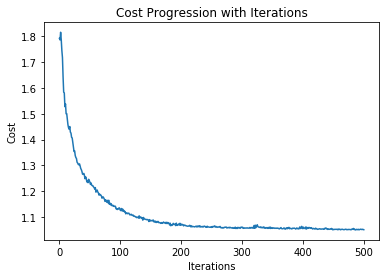

Train Accuracy:  99.41176176071167
Test Accuracy:  93.88889074325562
Max Test Accuracy: 97.22222089767456 on iteration 364
Learning rate:  0.012
Keep probability:  0.95
Time elapsed :  9.557994699478149
**********Learning rate******0.012********Keep prob***********0.92****lamda 10.0
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.2222222238779068
Accuracy Test: 0.22222222 on iteration 0
Cost is 1.7920198 for iteration: 0
Accuracy Test: 0.18333334 on iteration 1
Cost is 1.776064 for iteration: 1
Max till now is  0.2666666805744171
Accuracy Test: 0.26666668 on i

Accuracy Test: 0.8666667 on iteration 83
Cost is 1.1206806 for iteration: 83
Accuracy Test: 0.8333333 on iteration 84
Cost is 1.1259542 for iteration: 84
Accuracy Test: 0.8611111 on iteration 85
Cost is 1.120866 for iteration: 85
Accuracy Test: 0.8611111 on iteration 86
Cost is 1.1192007 for iteration: 86
Accuracy Test: 0.8611111 on iteration 87
Cost is 1.1146576 for iteration: 87
Accuracy Test: 0.8611111 on iteration 88
Cost is 1.1178199 for iteration: 88
Accuracy Test: 0.85 on iteration 89
Cost is 1.1137595 for iteration: 89
Accuracy Test: 0.87222224 on iteration 90
Cost is 1.1119977 for iteration: 90
Accuracy Test: 0.8611111 on iteration 91
Cost is 1.1113673 for iteration: 91
Accuracy Test: 0.85555553 on iteration 92
Cost is 1.1164665 for iteration: 92
Accuracy Test: 0.85 on iteration 93
Cost is 1.1107708 for iteration: 93
Accuracy Test: 0.87777776 on iteration 94
Cost is 1.1050506 for iteration: 94
Accuracy Test: 0.8611111 on iteration 95
Cost is 1.1022184 for iteration: 95
Accurac

Accuracy Test: 0.90555555 on iteration 186
Cost is 1.0587196 for iteration: 186
Accuracy Test: 0.9166667 on iteration 187
Cost is 1.0578641 for iteration: 187
Accuracy Test: 0.9111111 on iteration 188
Cost is 1.0606592 for iteration: 188
Accuracy Test: 0.9111111 on iteration 189
Cost is 1.0593425 for iteration: 189
Accuracy Test: 0.9 on iteration 190
Cost is 1.0608788 for iteration: 190
Accuracy Test: 0.8833333 on iteration 191
Cost is 1.062646 for iteration: 191
Accuracy Test: 0.9 on iteration 192
Cost is 1.0583667 for iteration: 192
Accuracy Test: 0.92777777 on iteration 193
Cost is 1.0576513 for iteration: 193
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.0582358 for iteration: 194
Accuracy Test: 0.9166667 on iteration 195
Cost is 1.0636064 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.0590725 for iteration: 196
Accuracy Test: 0.90555555 on iteration 197
Cost is 1.0632287 for iteration: 197
Accuracy Test: 0.9222222 on iteration 198
Cost is 1.063465 fo

Accuracy Test: 0.9166667 on iteration 290
Cost is 1.0533623 for iteration: 290
Accuracy Test: 0.95 on iteration 291
Cost is 1.051653 for iteration: 291
Accuracy Test: 0.92777777 on iteration 292
Cost is 1.0497707 for iteration: 292
Accuracy Test: 0.9166667 on iteration 293
Cost is 1.0507755 for iteration: 293
Accuracy Test: 0.93333334 on iteration 294
Cost is 1.0501183 for iteration: 294
Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0517187 for iteration: 295
Accuracy Test: 0.9166667 on iteration 296
Cost is 1.0524528 for iteration: 296
Accuracy Test: 0.9444444 on iteration 297
Cost is 1.0474958 for iteration: 297
Accuracy Test: 0.9 on iteration 298
Cost is 1.0490992 for iteration: 298
Accuracy Test: 0.9166667 on iteration 299
Cost is 1.0500119 for iteration: 299
Accuracy Test: 0.9222222 on iteration 300
Cost is 1.050587 for iteration: 300
Accuracy Test: 0.9388889 on iteration 301
Cost is 1.0469397 for iteration: 301
Accuracy Test: 0.9444444 on iteration 302
Cost is 1.051278 for 

Accuracy Test: 0.93333334 on iteration 394
Cost is 1.0515388 for iteration: 394
Accuracy Test: 0.9611111 on iteration 395
Cost is 1.0482831 for iteration: 395
Accuracy Test: 0.9388889 on iteration 396
Cost is 1.0477608 for iteration: 396
Accuracy Test: 0.95 on iteration 397
Cost is 1.050765 for iteration: 397
Accuracy Test: 0.93333334 on iteration 398
Cost is 1.0483378 for iteration: 398
Accuracy Test: 0.92777777 on iteration 399
Cost is 1.0470837 for iteration: 399
Accuracy Test: 0.9166667 on iteration 400
Cost is 1.0477366 for iteration: 400
Accuracy Test: 0.9166667 on iteration 401
Cost is 1.0498601 for iteration: 401
Accuracy Test: 0.92777777 on iteration 402
Cost is 1.0477631 for iteration: 402
Accuracy Test: 0.92777777 on iteration 403
Cost is 1.0479114 for iteration: 403
Accuracy Test: 0.93333334 on iteration 404
Cost is 1.0502886 for iteration: 404
Accuracy Test: 0.9222222 on iteration 405
Cost is 1.049499 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.

Accuracy Test: 0.9388889 on iteration 498
Cost is 1.0454524 for iteration: 498
Accuracy Test: 0.9388889 on iteration 499
Cost is 1.0458589 for iteration: 499
Accuracy Test: 0.95 on iteration 500
Cost is 1.0471053 for iteration: 500


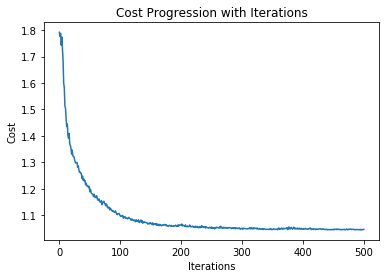

Train Accuracy:  99.90196228027344
Test Accuracy:  94.9999988079071
Max Test Accuracy: 96.11111283302307 on iteration 223
Learning rate:  0.012
Keep probability:  0.92
Time elapsed :  9.647032701969147
**********Learning rate******0.012********Keep prob***********0.92****lamda 0.1
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.2222222238779068
Accuracy Test: 0.22222222 on iteration 0
Cost is 1.7920198 for iteration: 0
Accuracy Test: 0.18333334 on iteration 1
Cost is 1.776064 for iteration: 1
Max till now is  0.2666666805744171
Accuracy Test: 0.26666668 on ite

Accuracy Test: 0.8666667 on iteration 83
Cost is 1.1206806 for iteration: 83
Accuracy Test: 0.8333333 on iteration 84
Cost is 1.1259542 for iteration: 84
Accuracy Test: 0.8611111 on iteration 85
Cost is 1.120866 for iteration: 85
Accuracy Test: 0.8611111 on iteration 86
Cost is 1.1192007 for iteration: 86
Accuracy Test: 0.8611111 on iteration 87
Cost is 1.1146576 for iteration: 87
Accuracy Test: 0.8611111 on iteration 88
Cost is 1.1178199 for iteration: 88
Accuracy Test: 0.85 on iteration 89
Cost is 1.1137595 for iteration: 89
Accuracy Test: 0.87222224 on iteration 90
Cost is 1.1119977 for iteration: 90
Accuracy Test: 0.8611111 on iteration 91
Cost is 1.1113673 for iteration: 91
Accuracy Test: 0.85555553 on iteration 92
Cost is 1.1164665 for iteration: 92
Accuracy Test: 0.85 on iteration 93
Cost is 1.1107708 for iteration: 93
Accuracy Test: 0.87777776 on iteration 94
Cost is 1.1050506 for iteration: 94
Accuracy Test: 0.8611111 on iteration 95
Cost is 1.1022184 for iteration: 95
Accurac

Accuracy Test: 0.90555555 on iteration 186
Cost is 1.0587196 for iteration: 186
Accuracy Test: 0.9166667 on iteration 187
Cost is 1.0578641 for iteration: 187
Accuracy Test: 0.9111111 on iteration 188
Cost is 1.0606592 for iteration: 188
Accuracy Test: 0.9111111 on iteration 189
Cost is 1.0593425 for iteration: 189
Accuracy Test: 0.9 on iteration 190
Cost is 1.0608788 for iteration: 190
Accuracy Test: 0.8833333 on iteration 191
Cost is 1.062646 for iteration: 191
Accuracy Test: 0.9 on iteration 192
Cost is 1.0583667 for iteration: 192
Accuracy Test: 0.92777777 on iteration 193
Cost is 1.0576513 for iteration: 193
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.0582358 for iteration: 194
Accuracy Test: 0.9166667 on iteration 195
Cost is 1.0636064 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.0590725 for iteration: 196
Accuracy Test: 0.90555555 on iteration 197
Cost is 1.0632287 for iteration: 197
Accuracy Test: 0.9222222 on iteration 198
Cost is 1.063465 fo

Accuracy Test: 0.9166667 on iteration 290
Cost is 1.0533623 for iteration: 290
Accuracy Test: 0.95 on iteration 291
Cost is 1.051653 for iteration: 291
Accuracy Test: 0.92777777 on iteration 292
Cost is 1.0497707 for iteration: 292
Accuracy Test: 0.9166667 on iteration 293
Cost is 1.0507755 for iteration: 293
Accuracy Test: 0.93333334 on iteration 294
Cost is 1.0501183 for iteration: 294
Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0517187 for iteration: 295
Accuracy Test: 0.9166667 on iteration 296
Cost is 1.0524528 for iteration: 296
Accuracy Test: 0.9444444 on iteration 297
Cost is 1.0474958 for iteration: 297
Accuracy Test: 0.9 on iteration 298
Cost is 1.0490992 for iteration: 298
Accuracy Test: 0.9166667 on iteration 299
Cost is 1.0500119 for iteration: 299
Accuracy Test: 0.9222222 on iteration 300
Cost is 1.050587 for iteration: 300
Accuracy Test: 0.9388889 on iteration 301
Cost is 1.0469397 for iteration: 301
Accuracy Test: 0.9444444 on iteration 302
Cost is 1.051278 for 

Accuracy Test: 0.93333334 on iteration 394
Cost is 1.0515388 for iteration: 394
Accuracy Test: 0.9611111 on iteration 395
Cost is 1.0482831 for iteration: 395
Accuracy Test: 0.9388889 on iteration 396
Cost is 1.0477608 for iteration: 396
Accuracy Test: 0.95 on iteration 397
Cost is 1.050765 for iteration: 397
Accuracy Test: 0.93333334 on iteration 398
Cost is 1.0483378 for iteration: 398
Accuracy Test: 0.92777777 on iteration 399
Cost is 1.0470837 for iteration: 399
Accuracy Test: 0.9166667 on iteration 400
Cost is 1.0477366 for iteration: 400
Accuracy Test: 0.9166667 on iteration 401
Cost is 1.0498601 for iteration: 401
Accuracy Test: 0.92777777 on iteration 402
Cost is 1.0477631 for iteration: 402
Accuracy Test: 0.92777777 on iteration 403
Cost is 1.0479114 for iteration: 403
Accuracy Test: 0.93333334 on iteration 404
Cost is 1.0502886 for iteration: 404
Accuracy Test: 0.9222222 on iteration 405
Cost is 1.049499 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.

Accuracy Test: 0.9388889 on iteration 498
Cost is 1.0454524 for iteration: 498
Accuracy Test: 0.9388889 on iteration 499
Cost is 1.0458589 for iteration: 499
Accuracy Test: 0.95 on iteration 500
Cost is 1.0471053 for iteration: 500


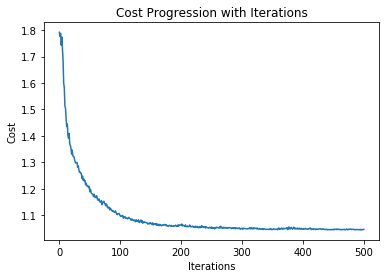

Train Accuracy:  99.90196228027344
Test Accuracy:  94.9999988079071
Max Test Accuracy: 96.11111283302307 on iteration 223
Learning rate:  0.012
Keep probability:  0.92
Time elapsed :  9.523535998662313
**********Learning rate******0.012********Keep prob***********0.85****lamda 10.0
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.20000000298023224
Accuracy Test: 0.2 on iteration 0
Cost is 1.7916032 for iteration: 0
Accuracy Test: 0.18888889 on iteration 1
Cost is 1.7954233 for iteration: 1
Accuracy Test: 0.2 on iteration 2
Cost is 1.808044 for iteration: 2
Max 

Accuracy Test: 0.8388889 on iteration 88
Cost is 1.1460656 for iteration: 88
Accuracy Test: 0.8055556 on iteration 89
Cost is 1.1387364 for iteration: 89
Accuracy Test: 0.8388889 on iteration 90
Cost is 1.1589425 for iteration: 90
Accuracy Test: 0.82222223 on iteration 91
Cost is 1.148104 for iteration: 91
Max till now is  0.8611111044883728
Accuracy Test: 0.8611111 on iteration 92
Cost is 1.1673466 for iteration: 92
Accuracy Test: 0.79444444 on iteration 93
Cost is 1.1561364 for iteration: 93
Accuracy Test: 0.84444445 on iteration 94
Cost is 1.1539667 for iteration: 94
Accuracy Test: 0.8055556 on iteration 95
Cost is 1.1276786 for iteration: 95
Accuracy Test: 0.8277778 on iteration 96
Cost is 1.1654485 for iteration: 96
Accuracy Test: 0.79444444 on iteration 97
Cost is 1.1446707 for iteration: 97
Accuracy Test: 0.84444445 on iteration 98
Cost is 1.1679243 for iteration: 98
Accuracy Test: 0.85 on iteration 99
Cost is 1.1289665 for iteration: 99
Max till now is  0.8722222447395325
Accur

Accuracy Test: 0.9111111 on iteration 190
Cost is 1.078394 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0756917 for iteration: 191
Accuracy Test: 0.9222222 on iteration 192
Cost is 1.0749886 for iteration: 192
Accuracy Test: 0.92777777 on iteration 193
Cost is 1.0679685 for iteration: 193
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.0732034 for iteration: 194
Accuracy Test: 0.89444447 on iteration 195
Cost is 1.0715771 for iteration: 195
Accuracy Test: 0.9111111 on iteration 196
Cost is 1.0731772 for iteration: 196
Accuracy Test: 0.8888889 on iteration 197
Cost is 1.0712209 for iteration: 197
Accuracy Test: 0.8833333 on iteration 198
Cost is 1.07236 for iteration: 198
Max till now is  0.9388889074325562
Accuracy Test: 0.9388889 on iteration 199
Cost is 1.0728127 for iteration: 199
Accuracy Test: 0.89444447 on iteration 200
Cost is 1.06916 for iteration: 200
Accuracy Test: 0.9166667 on iteration 201
Cost is 1.0742018 for iteration: 201
Accuracy Test: 0.

Accuracy Test: 0.9222222 on iteration 293
Cost is 1.0602772 for iteration: 293
Accuracy Test: 0.93333334 on iteration 294
Cost is 1.0588377 for iteration: 294
Accuracy Test: 0.9444444 on iteration 295
Cost is 1.0586997 for iteration: 295
Accuracy Test: 0.92777777 on iteration 296
Cost is 1.0618052 for iteration: 296
Accuracy Test: 0.92777777 on iteration 297
Cost is 1.056936 for iteration: 297
Accuracy Test: 0.92777777 on iteration 298
Cost is 1.0608718 for iteration: 298
Accuracy Test: 0.92777777 on iteration 299
Cost is 1.0628109 for iteration: 299
Accuracy Test: 0.9388889 on iteration 300
Cost is 1.0583808 for iteration: 300
Accuracy Test: 0.92777777 on iteration 301
Cost is 1.0617636 for iteration: 301
Accuracy Test: 0.9166667 on iteration 302
Cost is 1.0598955 for iteration: 302
Accuracy Test: 0.9222222 on iteration 303
Cost is 1.0580779 for iteration: 303
Accuracy Test: 0.9166667 on iteration 304
Cost is 1.0578027 for iteration: 304
Accuracy Test: 0.93333334 on iteration 305
Cost

Accuracy Test: 0.93333334 on iteration 397
Cost is 1.0528901 for iteration: 397
Accuracy Test: 0.93333334 on iteration 398
Cost is 1.0514643 for iteration: 398
Accuracy Test: 0.90555555 on iteration 399
Cost is 1.0544437 for iteration: 399
Accuracy Test: 0.93333334 on iteration 400
Cost is 1.0557103 for iteration: 400
Accuracy Test: 0.9222222 on iteration 401
Cost is 1.0546769 for iteration: 401
Accuracy Test: 0.93333334 on iteration 402
Cost is 1.0531982 for iteration: 402
Accuracy Test: 0.9611111 on iteration 403
Cost is 1.0554029 for iteration: 403
Accuracy Test: 0.9166667 on iteration 404
Cost is 1.0554444 for iteration: 404
Accuracy Test: 0.9444444 on iteration 405
Cost is 1.0541377 for iteration: 405
Accuracy Test: 0.9611111 on iteration 406
Cost is 1.0517564 for iteration: 406
Accuracy Test: 0.93333334 on iteration 407
Cost is 1.0544903 for iteration: 407
Accuracy Test: 0.9388889 on iteration 408
Cost is 1.0561013 for iteration: 408
Accuracy Test: 0.95555556 on iteration 409
Cos

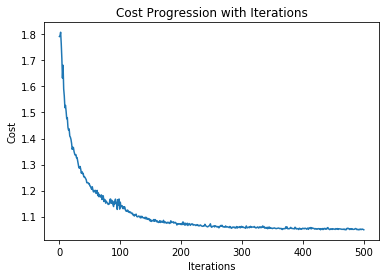

Train Accuracy:  99.50980544090271
Test Accuracy:  93.88889074325562
Max Test Accuracy: 96.66666388511658 on iteration 449
Learning rate:  0.012
Keep probability:  0.85
Time elapsed :  9.420187584559123
**********Learning rate******0.012********Keep prob***********0.85****lamda 0.1
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.20000000298023224
Accuracy Test: 0.2 on iteration 0
Cost is 1.7916032 for iteration: 0
Accuracy Test: 0.18888889 on iteration 1
Cost is 1.7954233 for iteration: 1
Accuracy Test: 0.2 on iteration 2
Cost is 1.808044 for iteration: 2
Max 

Accuracy Test: 0.8388889 on iteration 88
Cost is 1.1460656 for iteration: 88
Accuracy Test: 0.8055556 on iteration 89
Cost is 1.1387364 for iteration: 89
Accuracy Test: 0.8388889 on iteration 90
Cost is 1.1589425 for iteration: 90
Accuracy Test: 0.82222223 on iteration 91
Cost is 1.148104 for iteration: 91
Max till now is  0.8611111044883728
Accuracy Test: 0.8611111 on iteration 92
Cost is 1.1673466 for iteration: 92
Accuracy Test: 0.79444444 on iteration 93
Cost is 1.1561364 for iteration: 93
Accuracy Test: 0.84444445 on iteration 94
Cost is 1.1539667 for iteration: 94
Accuracy Test: 0.8055556 on iteration 95
Cost is 1.1276786 for iteration: 95
Accuracy Test: 0.8277778 on iteration 96
Cost is 1.1654485 for iteration: 96
Accuracy Test: 0.79444444 on iteration 97
Cost is 1.1446707 for iteration: 97
Accuracy Test: 0.84444445 on iteration 98
Cost is 1.1679243 for iteration: 98
Accuracy Test: 0.85 on iteration 99
Cost is 1.1289665 for iteration: 99
Max till now is  0.8722222447395325
Accur

Accuracy Test: 0.9111111 on iteration 190
Cost is 1.078394 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0756917 for iteration: 191
Accuracy Test: 0.9222222 on iteration 192
Cost is 1.0749886 for iteration: 192
Accuracy Test: 0.92777777 on iteration 193
Cost is 1.0679685 for iteration: 193
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.0732034 for iteration: 194
Accuracy Test: 0.89444447 on iteration 195
Cost is 1.0715771 for iteration: 195
Accuracy Test: 0.9111111 on iteration 196
Cost is 1.0731772 for iteration: 196
Accuracy Test: 0.8888889 on iteration 197
Cost is 1.0712209 for iteration: 197
Accuracy Test: 0.8833333 on iteration 198
Cost is 1.07236 for iteration: 198
Max till now is  0.9388889074325562
Accuracy Test: 0.9388889 on iteration 199
Cost is 1.0728127 for iteration: 199
Accuracy Test: 0.89444447 on iteration 200
Cost is 1.06916 for iteration: 200
Accuracy Test: 0.9166667 on iteration 201
Cost is 1.0742018 for iteration: 201
Accuracy Test: 0.

Accuracy Test: 0.9222222 on iteration 293
Cost is 1.0602772 for iteration: 293
Accuracy Test: 0.93333334 on iteration 294
Cost is 1.0588377 for iteration: 294
Accuracy Test: 0.9444444 on iteration 295
Cost is 1.0586997 for iteration: 295
Accuracy Test: 0.92777777 on iteration 296
Cost is 1.0618052 for iteration: 296
Accuracy Test: 0.92777777 on iteration 297
Cost is 1.056936 for iteration: 297
Accuracy Test: 0.92777777 on iteration 298
Cost is 1.0608718 for iteration: 298
Accuracy Test: 0.92777777 on iteration 299
Cost is 1.0628109 for iteration: 299
Accuracy Test: 0.9388889 on iteration 300
Cost is 1.0583808 for iteration: 300
Accuracy Test: 0.92777777 on iteration 301
Cost is 1.0617636 for iteration: 301
Accuracy Test: 0.9166667 on iteration 302
Cost is 1.0598955 for iteration: 302
Accuracy Test: 0.9222222 on iteration 303
Cost is 1.0580779 for iteration: 303
Accuracy Test: 0.9166667 on iteration 304
Cost is 1.0578027 for iteration: 304
Accuracy Test: 0.93333334 on iteration 305
Cost

Accuracy Test: 0.93333334 on iteration 397
Cost is 1.0528901 for iteration: 397
Accuracy Test: 0.93333334 on iteration 398
Cost is 1.0514643 for iteration: 398
Accuracy Test: 0.90555555 on iteration 399
Cost is 1.0544437 for iteration: 399
Accuracy Test: 0.93333334 on iteration 400
Cost is 1.0557103 for iteration: 400
Accuracy Test: 0.9222222 on iteration 401
Cost is 1.0546769 for iteration: 401
Accuracy Test: 0.93333334 on iteration 402
Cost is 1.0531982 for iteration: 402
Accuracy Test: 0.9611111 on iteration 403
Cost is 1.0554029 for iteration: 403
Accuracy Test: 0.9166667 on iteration 404
Cost is 1.0554444 for iteration: 404
Accuracy Test: 0.9444444 on iteration 405
Cost is 1.0541377 for iteration: 405
Accuracy Test: 0.9611111 on iteration 406
Cost is 1.0517564 for iteration: 406
Accuracy Test: 0.93333334 on iteration 407
Cost is 1.0544903 for iteration: 407
Accuracy Test: 0.9388889 on iteration 408
Cost is 1.0561013 for iteration: 408
Accuracy Test: 0.95555556 on iteration 409
Cos

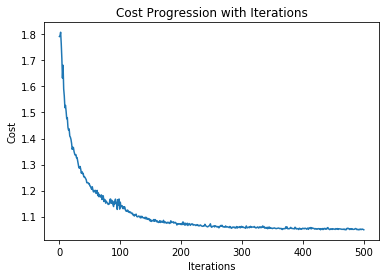

Train Accuracy:  99.50980544090271
Test Accuracy:  93.88889074325562
Max Test Accuracy: 96.66666388511658 on iteration 449
Learning rate:  0.012
Keep probability:  0.85
Time elapsed :  9.409365566571553
**********Learning rate******0.012********Keep prob***********0.75****lamda 10.0
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.23333333432674408
Accuracy Test: 0.23333333 on iteration 0
Cost is 1.7920785 for iteration: 0
Accuracy Test: 0.22222222 on iteration 1
Cost is 1.7972935 for iteration: 1
Accuracy Test: 0.15 on iteration 2
Cost is 1.759977 for iteratio

Accuracy Test: 0.8277778 on iteration 88
Cost is 1.1708043 for iteration: 88
Accuracy Test: 0.81666666 on iteration 89
Cost is 1.1729746 for iteration: 89
Accuracy Test: 0.8111111 on iteration 90
Cost is 1.1612102 for iteration: 90
Accuracy Test: 0.81666666 on iteration 91
Cost is 1.1640116 for iteration: 91
Max till now is  0.8722222447395325
Accuracy Test: 0.87222224 on iteration 92
Cost is 1.1595584 for iteration: 92
Accuracy Test: 0.85 on iteration 93
Cost is 1.1538414 for iteration: 93
Accuracy Test: 0.8 on iteration 94
Cost is 1.1510209 for iteration: 94
Accuracy Test: 0.8111111 on iteration 95
Cost is 1.1498857 for iteration: 95
Accuracy Test: 0.87222224 on iteration 96
Cost is 1.139407 for iteration: 96
Accuracy Test: 0.8277778 on iteration 97
Cost is 1.141951 for iteration: 97
Accuracy Test: 0.8333333 on iteration 98
Cost is 1.147148 for iteration: 98
Accuracy Test: 0.8388889 on iteration 99
Cost is 1.1425381 for iteration: 99
Accuracy Test: 0.84444445 on iteration 100
Cost is

Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0842638 for iteration: 191
Max till now is  0.9277777671813965
Accuracy Test: 0.92777777 on iteration 192
Cost is 1.0846248 for iteration: 192
Accuracy Test: 0.9222222 on iteration 193
Cost is 1.0779785 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.078594 for iteration: 194
Accuracy Test: 0.89444447 on iteration 195
Cost is 1.0843345 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.0788828 for iteration: 196
Accuracy Test: 0.9 on iteration 197
Cost is 1.0772743 for iteration: 197
Accuracy Test: 0.8888889 on iteration 198
Cost is 1.078723 for iteration: 198
Max till now is  0.9333333373069763
Accuracy Test: 0.93333334 on iteration 199
Cost is 1.0765272 for iteration: 199
Accuracy Test: 0.9166667 on iteration 200
Cost is 1.0712985 for iteration: 200
Accuracy Test: 0.9111111 on iteration 201
Cost is 1.0775181 for iteration: 201
Accuracy Test: 0.9111111 on iteration 202
Cost is 1.0767156 for iter

Accuracy Test: 0.92777777 on iteration 294
Cost is 1.0679808 for iteration: 294
Accuracy Test: 0.89444447 on iteration 295
Cost is 1.0601614 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0757973 for iteration: 296
Accuracy Test: 0.9111111 on iteration 297
Cost is 1.0666369 for iteration: 297
Accuracy Test: 0.9222222 on iteration 298
Cost is 1.0619948 for iteration: 298
Accuracy Test: 0.9444444 on iteration 299
Cost is 1.0688037 for iteration: 299
Accuracy Test: 0.90555555 on iteration 300
Cost is 1.0664647 for iteration: 300
Accuracy Test: 0.8833333 on iteration 301
Cost is 1.066838 for iteration: 301
Accuracy Test: 0.9166667 on iteration 302
Cost is 1.0651581 for iteration: 302
Accuracy Test: 0.92777777 on iteration 303
Cost is 1.0588354 for iteration: 303
Accuracy Test: 0.9222222 on iteration 304
Cost is 1.06348 for iteration: 304
Accuracy Test: 0.92777777 on iteration 305
Cost is 1.071288 for iteration: 305
Accuracy Test: 0.9388889 on iteration 306
Cost is 

Accuracy Test: 0.9222222 on iteration 397
Cost is 1.0567565 for iteration: 397
Max till now is  0.9722222089767456
Accuracy Test: 0.9722222 on iteration 398
Cost is 1.059268 for iteration: 398
Accuracy Test: 0.9166667 on iteration 399
Cost is 1.0571116 for iteration: 399
Accuracy Test: 0.95555556 on iteration 400
Cost is 1.0560253 for iteration: 400
Accuracy Test: 0.9166667 on iteration 401
Cost is 1.054787 for iteration: 401
Accuracy Test: 0.93333334 on iteration 402
Cost is 1.0553744 for iteration: 402
Accuracy Test: 0.92777777 on iteration 403
Cost is 1.0601884 for iteration: 403
Accuracy Test: 0.9166667 on iteration 404
Cost is 1.0540413 for iteration: 404
Accuracy Test: 0.9111111 on iteration 405
Cost is 1.0584295 for iteration: 405
Accuracy Test: 0.9 on iteration 406
Cost is 1.0571691 for iteration: 406
Accuracy Test: 0.9444444 on iteration 407
Cost is 1.0565292 for iteration: 407
Accuracy Test: 0.9444444 on iteration 408
Cost is 1.0582513 for iteration: 408
Accuracy Test: 0.9277

Accuracy Test: 0.93333334 on iteration 500
Cost is 1.0564188 for iteration: 500


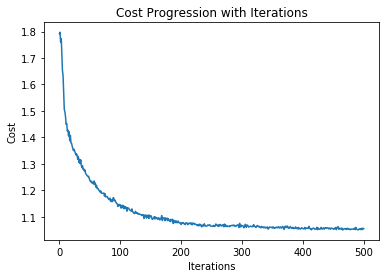

Train Accuracy:  99.21568632125854
Test Accuracy:  93.33333373069763
Max Test Accuracy: 97.77777791023254 on iteration 461
Learning rate:  0.012
Keep probability:  0.75
Time elapsed :  9.43056165377299
**********Learning rate******0.012********Keep prob***********0.75****lamda 0.1
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.23333333432674408
Accuracy Test: 0.23333333 on iteration 0
Cost is 1.7920785 for iteration: 0
Accuracy Test: 0.22222222 on iteration 1
Cost is 1.7972935 for iteration: 1
Accuracy Test: 0.15 on iteration 2
Cost is 1.759977 for iteration:

Accuracy Test: 0.8277778 on iteration 88
Cost is 1.1708043 for iteration: 88
Accuracy Test: 0.81666666 on iteration 89
Cost is 1.1729746 for iteration: 89
Accuracy Test: 0.8111111 on iteration 90
Cost is 1.1612102 for iteration: 90
Accuracy Test: 0.81666666 on iteration 91
Cost is 1.1640116 for iteration: 91
Max till now is  0.8722222447395325
Accuracy Test: 0.87222224 on iteration 92
Cost is 1.1595584 for iteration: 92
Accuracy Test: 0.85 on iteration 93
Cost is 1.1538414 for iteration: 93
Accuracy Test: 0.8 on iteration 94
Cost is 1.1510209 for iteration: 94
Accuracy Test: 0.8111111 on iteration 95
Cost is 1.1498857 for iteration: 95
Accuracy Test: 0.87222224 on iteration 96
Cost is 1.139407 for iteration: 96
Accuracy Test: 0.8277778 on iteration 97
Cost is 1.141951 for iteration: 97
Accuracy Test: 0.8333333 on iteration 98
Cost is 1.147148 for iteration: 98
Accuracy Test: 0.8388889 on iteration 99
Cost is 1.1425381 for iteration: 99
Accuracy Test: 0.84444445 on iteration 100
Cost is

Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0842638 for iteration: 191
Max till now is  0.9277777671813965
Accuracy Test: 0.92777777 on iteration 192
Cost is 1.0846248 for iteration: 192
Accuracy Test: 0.9222222 on iteration 193
Cost is 1.0779785 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.078594 for iteration: 194
Accuracy Test: 0.89444447 on iteration 195
Cost is 1.0843345 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.0788828 for iteration: 196
Accuracy Test: 0.9 on iteration 197
Cost is 1.0772743 for iteration: 197
Accuracy Test: 0.8888889 on iteration 198
Cost is 1.078723 for iteration: 198
Max till now is  0.9333333373069763
Accuracy Test: 0.93333334 on iteration 199
Cost is 1.0765272 for iteration: 199
Accuracy Test: 0.9166667 on iteration 200
Cost is 1.0712985 for iteration: 200
Accuracy Test: 0.9111111 on iteration 201
Cost is 1.0775181 for iteration: 201
Accuracy Test: 0.9111111 on iteration 202
Cost is 1.0767156 for iter

Accuracy Test: 0.92777777 on iteration 294
Cost is 1.0679808 for iteration: 294
Accuracy Test: 0.89444447 on iteration 295
Cost is 1.0601614 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0757973 for iteration: 296
Accuracy Test: 0.9111111 on iteration 297
Cost is 1.0666369 for iteration: 297
Accuracy Test: 0.9222222 on iteration 298
Cost is 1.0619948 for iteration: 298
Accuracy Test: 0.9444444 on iteration 299
Cost is 1.0688037 for iteration: 299
Accuracy Test: 0.90555555 on iteration 300
Cost is 1.0664647 for iteration: 300
Accuracy Test: 0.8833333 on iteration 301
Cost is 1.066838 for iteration: 301
Accuracy Test: 0.9166667 on iteration 302
Cost is 1.0651581 for iteration: 302
Accuracy Test: 0.92777777 on iteration 303
Cost is 1.0588354 for iteration: 303
Accuracy Test: 0.9222222 on iteration 304
Cost is 1.06348 for iteration: 304
Accuracy Test: 0.92777777 on iteration 305
Cost is 1.071288 for iteration: 305
Accuracy Test: 0.9388889 on iteration 306
Cost is 

Accuracy Test: 0.9222222 on iteration 397
Cost is 1.0567565 for iteration: 397
Max till now is  0.9722222089767456
Accuracy Test: 0.9722222 on iteration 398
Cost is 1.059268 for iteration: 398
Accuracy Test: 0.9166667 on iteration 399
Cost is 1.0571116 for iteration: 399
Accuracy Test: 0.95555556 on iteration 400
Cost is 1.0560253 for iteration: 400
Accuracy Test: 0.9166667 on iteration 401
Cost is 1.054787 for iteration: 401
Accuracy Test: 0.93333334 on iteration 402
Cost is 1.0553744 for iteration: 402
Accuracy Test: 0.92777777 on iteration 403
Cost is 1.0601884 for iteration: 403
Accuracy Test: 0.9166667 on iteration 404
Cost is 1.0540413 for iteration: 404
Accuracy Test: 0.9111111 on iteration 405
Cost is 1.0584295 for iteration: 405
Accuracy Test: 0.9 on iteration 406
Cost is 1.0571691 for iteration: 406
Accuracy Test: 0.9444444 on iteration 407
Cost is 1.0565292 for iteration: 407
Accuracy Test: 0.9444444 on iteration 408
Cost is 1.0582513 for iteration: 408
Accuracy Test: 0.9277

Accuracy Test: 0.93333334 on iteration 500
Cost is 1.0564188 for iteration: 500


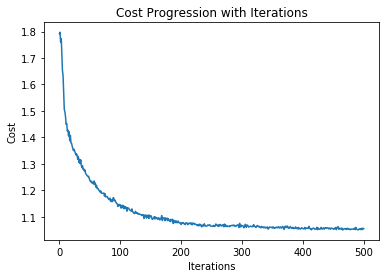

Train Accuracy:  99.21568632125854
Test Accuracy:  93.33333373069763
Max Test Accuracy: 97.77777791023254 on iteration 461
Learning rate:  0.012
Keep probability:  0.75
Time elapsed :  9.47276992003123


In [8]:
for learning_rate in [0.012]:
    for keep_prob in [0.95, 0.92, 0.85, 0.75]:
        for lam in [10.0, 0.1]:
            print("**********Learning rate******{}********Keep prob***********{}****lamda {}".format(learning_rate, keep_prob, lam))
            train_cnn_lenet5(500, X_train_norm, y_train_encoded, X_test_norm, y_test_encoded, learning_rate, keep_prob, lam)

### 5. (20pts) Predictions

#### 